# 3.1 - Univariate, Single Predictor Linear Regression

#### Disclaimer:

IQ is, at best, a misleading measure of a poorly-defined social construct
and, at worst, a nefarious tool of social control and scientific racism at worst.
I'm merely using this data because it is freely available
and I can work off of pre-existing examples.

In [1]:
import pystan

In [2]:
import statsmodels.formula.api as smf

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=3)

In [4]:
%matplotlib inline

Data can be downloaded from [here](http://www.stat.columbia.edu/~gelman/arm/software/).

We start with the simplest model: univariate binary linear regression with a Gaussian noise model,
aka fitting our data as binary mixture of Gaussians with the same variance.

## Visualizing the Data

We first load the data.

In [5]:
kid_path = "../ARM_Data/child.iq/kidiq.dta"
kid_df =  pd.io.stata.read_stata(kid_path)
kid_df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


And then we pick an appropriate visualization.

The model we've chosen to start with
splits the data into groups based off of one variable,
and then predicts the target variable by the group means,
so a good visualization should split the data into those groups.

For example:

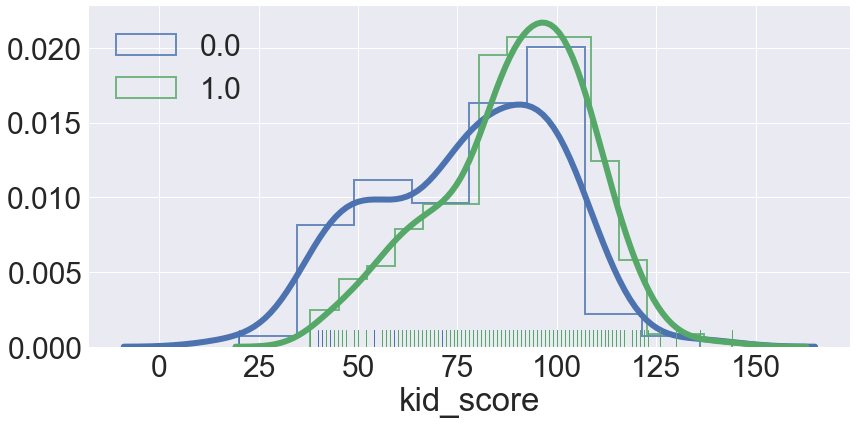

In [6]:
g = sns.FacetGrid(kid_df, hue="mom_hs", size=6, aspect=2)
g = g.map(sns.distplot, "kid_score", rug=True, kde_kws = {'linewidth':6},
          hist_kws = {"histtype":"step", "alpha":0.8, "linewidth":2},
         )
plt.legend();

This data doesn't look like a perfect fit for a linear model:
though the shapes of the distributions are somewhat similar,
they are not very Gaussian.

We soldier on regardless, because this is a classic example.

## Traditional Least Squares in `statsmodels`

`statsmodels` is a package for describing and fitting various generalized linear models.

Our model is an `o`rdinary `l`east `s`quares model.
We will attempt to predict child IQ using only knowledge
of whether the child's mother completed high school.

Let $y$ denote a vector of child IQs,
$x$ denote the matched vector of booleans indicating
maternal high school completion,
and $i$ index children.

We define a model, or mapping $\{0,1\}\rightarrow\mathbb{R}$,
parameterized by $\beta_0$ and $\beta_1$ such that

$$
y_i = x_i\cdot \beta_0 + \beta_1 + \epsilon_i
$$

where this equation serves as a definition of $\epsilon$.

Our goal is to make the squared value of $\epsilon$ as small as possible.

We do this via the appropriately named method of *least squares*.

We first select random training and test sets to fit our models to.

In [7]:
def train_test_split(df, train_fraction=0.8):
    total_N = len(kid_df)
    test_fraction = 1-train_fraction
    
    train_set_size = int(total_N*train_fraction); test_set_size = total_N - train_set_size

    train_set_indices = np.random.choice(total_N, size=train_set_size, replace=False)
    
    train_df = df.iloc[train_set_indices]
    test_df = df.iloc[[index for index in range(total_N) if index not in train_set_indices]]
    
    return train_df, test_df

In [8]:
train_df, test_df = train_test_split(kid_df)

We now pass the training set and an R-style description of our model,
called a *formula*, to `statsmodels`,
and it will fit the $\beta$ parameters.

Formulas will later allow us to express very complex models,
with multiple levels, hidden variables, and (fixed) nonlinear data transforms.
For now, because our model is so simple,
the formula is exceedingly simple as well:

```
y ~ x
```

where `y` and `x` are the variable names.

In [9]:
mom_hs_mod = smf.ols("kid_score ~ mom_hs", data=train_df)

mom_hs_results = mom_hs_mod.fit()

We print the results.

In [10]:
print(mom_hs_results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     24.49
Date:                Mon, 26 Feb 2018   Prob (F-statistic):           1.17e-06
Time:                        11:44:13   Log-Likelihood:                -1530.7
No. Observations:                 347   AIC:                             3065.
Df Residuals:                     345   BIC:                             3073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.9481      2.278     33.783      0.0

Here, $\beta_1$ is called the `Intercept` for obvious reasons,
while $\beta_0$ inherits the name `mom_hs` from our dataframe.

We note the following:
1. Child IQs are significantly different from 0 (whew).
1. Maternal high school achievement has a highly *statistically* significant effect on child IQ: `p<5e-4`.
1. Our predicted IQ for a child of a mother who finished high school is 11 points higher than that for a child whose mother didn't finish high school. 
1. The $R^2$ values are miniscule, indicating this relationship is very weak.

The first-pass interpretation of these results is that
the maternal educational attainment has a weak, but detectable relationship to child IQ
(note we can't infer causation here).

Exactly how weak is this relationship though?
We already have a sense that the relationship is weak,
from the $R^2$ value,
but I personally have a hard time just reading these values
and getting a gut feeling for the strength of the relationship.

I prefer to look at the errors our model makes instead.

First, we get model predictions for unseen data points
(so that we don't fool ourselves into thinking our model is better than it is).

In [11]:
mom_hs_predicted_kid_scores = mom_hs_results.get_prediction(test_df).predicted_mean

Then, we compute the mean squared error and root mean squared error of those predictions.

In [12]:
mom_hs_errors = test_df.kid_score-mom_hs_predicted_kid_scores
mom_hs_mse = np.var(mom_hs_errors,ddof=1)
mom_hs_rmse = np.sqrt(mom_hs_mse)
mom_hs_rmse

19.425723956744566

Compare this model error to the putative effect size, $\approx 11.5$.
The model error is larger,
indicating that variation in IQ related to factors we didn't consider
is larger than the variation in IQ related to maternal high school graduation.

An alternative metric for model utility is to compare the average squared error of the model
to the average squared error of the best model that is ignorant of the value of `x`:
a model that just predicts each child has the average IQ of the cohort.

We take the ratio of these two quantities 
to determine just how much squared error is,
on average, left over when we include our model prediction.

In [13]:
mom_hs_remaining_variance = mom_hs_mse/test_df.kid_score.var()
mom_hs_remaining_variance

0.9903442519395147

Not too compelling.

## Bayesian Regression in `stan`: First Pass

In Bayesian regression,
we instead compute posteriors over our parameters
and our missing data.

This is substantially more complex than making point estimates,
and this is reflected in the greater complexity and computational load
of packages for Bayesian regression (and inference in general).

`stan` is one such package -- fundamentally, it is a `C++` package that we interact with from Python.
To start, we must specify our variables in a `C`-style syntax.

The following code is adopted from [this tutorial on Bayesian regression](https://www.r-bloggers.com/bayesian-regression-with-stan-part-1-normal-regression/).

To work with `stan`, we must slightly reorient our thinking.
Instead of specifying the model component-wise,
we specify it as collection of matrix and vector operations:

$$
Y = X\cdot\beta + \epsilon
$$

where $Y$ is a matrix of observed values (here an $N \times 1$ matrix)
and $X$ is the so-called "design" matrix and has dimensions $(N,K)$.
It contains the values of the predictor in its first column.
In general, it's allowed to have any other potential predictor
as its other columns, including non-linear transformations $\phi_i$ of other predictors.

Recall that we wanted our model to include an *affine* transformation,
aka a non-zero intercept.
To mimic this affine transformation,
we choose the non-linear transformation
$$
\phi_1(x) = 1
$$
to generate the second column of $X$.
That is, the second column of $X$ is just a column of $1$s,
allowing us to "cheat" and represent an affine transformation with linear operations.

We begin by specifying the shapes and types of the things we will provide the model:
the testing data and the training data (in the form of the design matrix).

In [14]:
data_code = """data {
  int N_train; //the number of training set examples
  int N_test; //the number of test set examples
  int K; //the number of columns in the model matrix
  real y[N_train]; //the response
  matrix[N_train,K] train_X; //the design matrix for the training set
  matrix[N_test,K] test_X; //the design matrix for the test set
}"""

We then specify the parameters of the model,
which now include a standard deviation for the errors.

In [15]:
parameters_code = """parameters {
  vector[K] beta; //the regression parameters
  real<lower=0> sigma; //the standard deviation
}"""

We now specify how the model's predictions are generated from its parameters.

In [16]:
prediction_code = """transformed parameters {
  vector[N_train] linear_prediction;
  linear_prediction <- train_X*beta;
}"""

Next, we must specify our model:
what is the conditional distribution of the target variable?
Note for the True Bayesians in the room:
by failing to specify a prior for our hyperparameters,
we select the default, which is an improper "flat prior".

In [17]:
model_code = """model {  
  y ~ normal(linear_prediction,sigma); // conditional of the target
}"""

Finally, we must specify how predictions are to generated from our model.

In [18]:
test_prediction_code = """generated quantities {
  vector[N_test] y_pred;
  y_pred <- test_X*beta; //the y values predicted by the model
}"""

We then combine this together by string concatenation
to produce the code for the whole model.

In [19]:
mom_hs_model_code = data_code+parameters_code+prediction_code+model_code+test_prediction_code

In [20]:
mom_hs_stanmodel = pystan.StanModel(model_code=mom_hs_model_code, model_name='mom_hs')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL mom_hs_45389953cd287b4929d0e5dff33a664d NOW.


We now construct the design matrices.

In [21]:
def make_design_matrix(df, var, add_interaction=False):
    variables = np.atleast_2d(df[var])
    if variables.shape[0] == 1:
        variables = variables.T
    if add_interaction:
        variables = add_interaction_term(variables, cols=[0,1])
    return np.hstack([variables, np.expand_dims(make_affine_term(df[var]),axis=1)])

def add_interaction_term(design_matrix, cols=[0,1]):
    interaction_column = np.expand_dims(np.multiply(design_matrix[:,cols[0]], design_matrix[:,cols[1]]),1)
    return np.hstack([design_matrix, interaction_column])

def make_affine_term(data):
    return np.ones(shape=data.shape[0])

mom_hs_design_matrix = make_design_matrix(train_df, "mom_hs")
mom_hs_test_design_matrix = make_design_matrix(test_df, "mom_hs")

We organize the model parameters into a dictionary to be fed into the model.

In [22]:
mom_hs_data = {'N_train': len(train_df),
           'N_test': len(test_df),
               'K': 2,
               'y': train_df.kid_score,
              'train_X': mom_hs_design_matrix,
          'test_X': mom_hs_test_design_matrix}

Computing exactly in Bayesian networks is difficult,
so we instead choose to compute approximately, by sampling.

In [23]:
mom_hs_samples = mom_hs_stanmodel.sampling(data=mom_hs_data, iter=1000, chains=4)

/Users/charlesfrye/anaconda3/envs/graph_models/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In sampling-based Bayesian computation,
we compute the expected value of quantities of interest under the (sample-approximated) posterior distribution.

That is a fancy way of saying that we just compute the desired quantity on each of our samples and take the average.

To do so,
we first extract all of the predictions,
compute the error for each score in each sample,
and then take the (root) mean square of that entire array of quantities.

In [24]:
train_predictions = mom_hs_samples.extract("linear_prediction")["linear_prediction"]
test_predictions = mom_hs_samples.extract("y_pred")["y_pred"]

In [25]:
def compute_errors(predictions, observed_values):
    errors = predictions - np.asarray(observed_values)
    return errors

In [26]:
train_errors = compute_errors(train_predictions, train_df.kid_score)
test_errors = compute_errors(test_predictions, test_df.kid_score)

In [27]:
mom_hs_samples_mse = np.var(test_errors,ddof=1)

In [28]:
np.sqrt(mom_hs_samples_mse)

19.36761355818524

In [29]:
mom_hs_samples_mse/test_df.kid_score.var()

0.9844280531501347

For such a simple problem,
we don't get any benefit from using Bayesian methods.
Worse still,
the fact that our model is mis-specified probably hurts us more in this case.

One of the cool things about going Bayesian
is that we get a real sense of how uncertain we are about our parameters,
in a much more concrete way than is captured in a confidence interval.

We simply need to look at the sampled values of the parameters.

In [30]:
betas = mom_hs_samples.extract('beta')['beta']

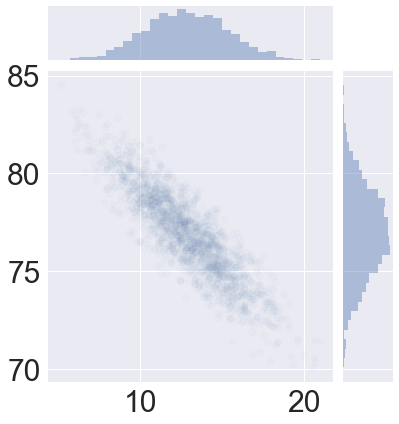

In [31]:
sns.jointplot(betas[:,0], betas[:,1], stat_func=None, joint_kws={"alpha":0.025});

Note that we get a *joint* uncertainty!
This is another aspect of uncertainty that is poorly captured by ML models and parametric stats
(though we can recover it with bootstrapping).

## Bayesian Regression in `stan`: Second Pass

As models get more complicated,
it will become ever more difficult to write equations that describe them.
And further, the notation in equations is ill-suited to clearly specifying
the components of a probabilistic model and their relationships.

Enter *graphical models*,
a visual, graph-based method for specifying probabilistic models.
In brief,
we assign a node to each of the random variables that are part of our model
and then draw a directed edge between a variable that directly influences the distribution
of another variable.

For a
short introduction to graphical models in the context of information theory,
check out
[this blog post](http://charlesfrye.github.io/stats/2017/09/26/discrete-channel-graph-model.html).
For a
more thorough introduction to graphical models and the associated variational perspective on inference,
[see this monograph](https://people.eecs.berkeley.edu/~wainwrig/Papers/WaiJor08_FTML.pdf).

What are the random variables in our model?
The two most obvious ones are the ones we observe:
$x$ and $y$.
Because we want to write a model that predicts values of $y$ given values of $x$,
we draw an edge from $x$ to $y$.

Because we are being Bayesian,
we also consider *the parameters of the model* to be random variables.
That is, we frame our uncertainty about the true parameters of the model as
a probability distribution over the space of possible parameters.

That gives us one node for the $\beta$ vector
and one node for the variability of the residuals, $\sigma$.

The result is this model below:

<img src="../graph_diagrams/linear_regression.png" style="width: 300px;"/>

where the central box is called a "plate"
and indicates that there are $N$ independent copies of the contents in our full model.
Note that $\beta$ and $\sigma$ are outside the plate;
that's because there is only one parameter set for all of our data,
rather than different parameters for different subsets.

The $x$ and $y$ nodes are colored in because we have access to the values of $x$ and $y$ for all $N$ data points;
such variables are sometimes called *observed* or *visible* variables.
The $\beta$ and $\sigma$ nodes are transparent because we do not have access to their true values;
such variables are called *latent* or *hidden* variables.

In addition to specifying conditional distributions,
we should specify marginal distributions over our parameters:
ignoring the data, what is the chance that the parameter $\beta_1$ is equal to a given value?

These distributions are called *priors*, since they represent our prior knowledge.
To recover the normal form of least squares regression,
we should choose an *uninformative* or *flat* prior:
each value is equally likely.
Note that this causes some mathematical issues
for parameters that take values on sets with infinite width, e.g. the whole real line or all positive integers,
since the probability will drop to 0 as we spread attempt to spread it equally
across more and more possibilities.
This is called an *improper* prior.

For now, impropriety doesn't cause us any problems,
so we forge ahead.

We rewrite the `stan` model code to emphasize the graphical model structure.

In [39]:
data_code = """data {
  int<lower=0> N;
  vector<lower=0, upper=200>[N] y;
  vector<lower=0, upper=1>[N] x;
}"""

parameters_code = """parameters {
  vector[2] beta;
  real<lower=0> sigma;
}"""

model_code = """
model { // encodes the edges in our graph
  y ~ normal(beta[1] + beta[2] * x, sigma);
}"""

In [40]:
graphical_model_code = data_code+parameters_code+model_code

graphical_stanmodel = pystan.StanModel(model_code=graphical_model_code, model_name='graphical_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL graphical_model_b2f6367c43d0e8f7c20ca17595e13fff NOW.


In [41]:
graphical_model_data = {'N': len(train_df),
               'y': train_df.kid_score,
              'x': train_df.mom_hs,
              }

In [43]:
samples = graphical_stanmodel.sampling(data=graphical_model_data, iter=1000, chains=4);

/Users/charlesfrye/anaconda3/envs/graph_models/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
